In [1]:
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from fastai import *
from fastai.vision import *

In [2]:
ds_root = Path('./datasets/rtsd-r3-cut2500')

In [3]:
size = (64, 64)
bs = 512


df = pd.read_csv(ds_root / 'labels.csv', index_col='image_name')


def get_label(p):
    img_name = p.name
    return df.loc[img_name]['label']


data = (ImageList.from_folder(ds_root)
        .split_by_folder(train='train', valid='val')
        .label_from_func(get_label)
        .transform(get_transforms(), size=size) 
        .databunch(bs=bs)
        .normalize(imagenet_stats))

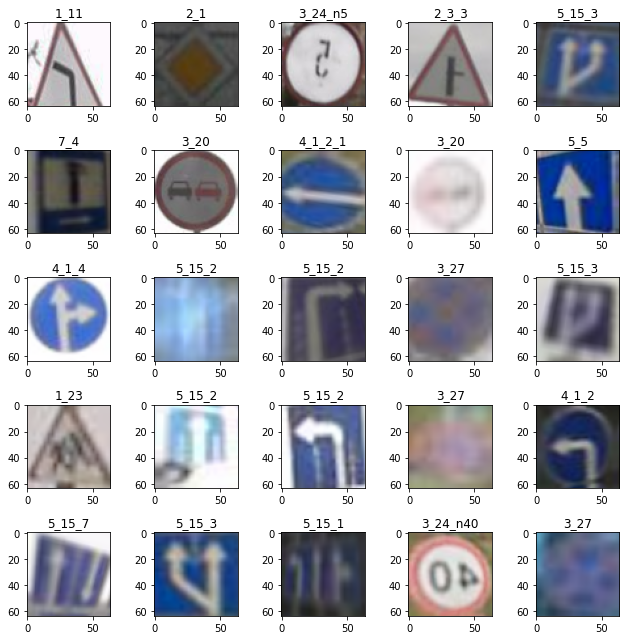

In [4]:
data.show_batch(5, figsize=(9, 9), hide_axis=False)

In [5]:
learn = cnn_learner(data, models.squeezenet1_1, metrics=[accuracy]).to_fp16().mixup()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


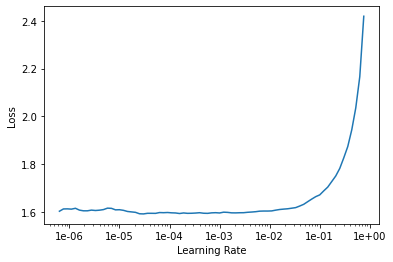

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(9, 6e-3, wd=1e-7)

epoch,train_loss,valid_loss,accuracy,time
0,1.619392,0.479000,0.883539,00:16
1,1.653846,0.526167,0.864587,00:16
2,1.709548,0.545946,0.861418,00:16
3,1.704393,0.538027,0.863368,00:16
4,1.687858,0.530556,0.868487,00:16
5,1.669947,0.509244,0.874276,00:16
6,1.645051,0.493927,0.876470,00:16
7,1.631094,0.481176,0.882747,00:16
8,1.610710,0.480168,0.883174,00:16


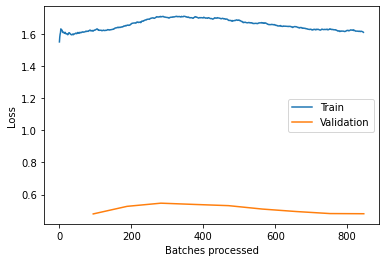

In [22]:
learn.recorder.plot_losses()

In [23]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


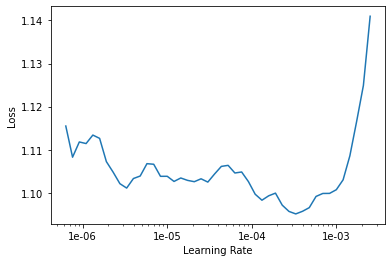

In [44]:
learn.lr_find()
learn.recorder.plot()

In [45]:
learn.fit_one_cycle(12, slice(1e-6, 7e-5), moms=(0.7, 0.5), wd=1e-8)

epoch,train_loss,valid_loss,accuracy,time
0,1.082054,0.157516,0.964714,00:17
1,1.085472,0.157057,0.965080,00:17
2,1.085162,0.159405,0.964288,00:17
3,1.082722,0.157405,0.964227,00:17
4,1.088392,0.159389,0.965324,00:17
5,1.081502,0.158412,0.964471,00:17
6,1.081930,0.159330,0.965324,00:17
7,1.074853,0.156667,0.965811,00:17
8,1.077361,0.156031,0.965202,00:17
9,1.083040,0.155435,0.965629,00:17


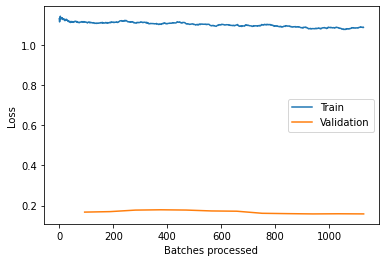

In [41]:
learn.recorder.plot_losses()

In [46]:
learn.save('m64x64s2_strange')

In [48]:
learn.destroy()
learn = cnn_learner(data, models.squeezenet1_1, metrics=[accuracy]).to_fp16()  # , wd=1e-4
learn.load('m64x64s2_strange');

this Learner object self-destroyed - it still exists, but no longer usable


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


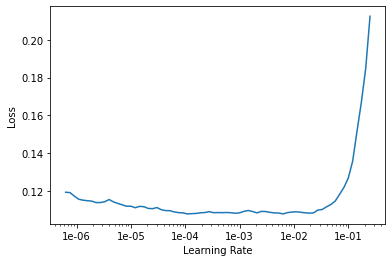

In [52]:
learn.lr_find()
learn.recorder.plot()

In [50]:
learn.fit_one_cycle(7, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.193616,0.106139,0.964471,00:16
1,0.153878,0.095798,0.964775,00:16
2,0.143233,0.089985,0.966787,00:16
3,0.132035,0.085573,0.969224,00:15
4,0.124337,0.082237,0.970931,00:16
5,0.118003,0.079627,0.971662,00:16
6,0.113405,0.079087,0.971418,00:16


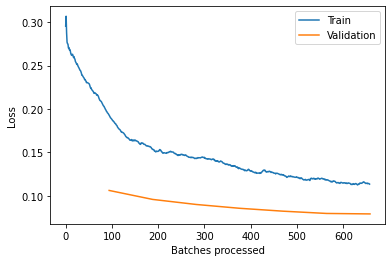

In [51]:
learn.recorder.plot_losses()

In [53]:
learn.save('m64x64s1_strange2')

In [59]:
learn.destroy()
learn = cnn_learner(data, models.squeezenet1_1, metrics=[accuracy], wd=1e-4).to_fp16()
learn.load('m64x64s2_strange2');

this Learner object self-destroyed - it still exists, but no longer usable


In [60]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


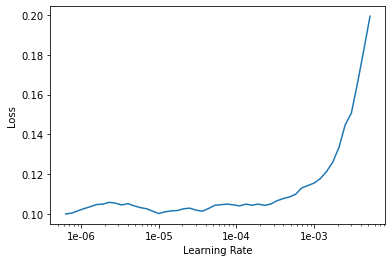

In [61]:
learn.lr_find()
learn.recorder.plot()

In [62]:
learn.fit_one_cycle(8, slice(2e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.103191,0.074989,0.973551,00:18
1,0.107786,0.075777,0.973125,00:17
2,0.105326,0.075406,0.973246,00:17
3,0.104472,0.076703,0.973185,00:17
4,0.101861,0.075127,0.973673,00:16
5,0.096731,0.075399,0.973125,00:17
6,0.097877,0.074540,0.973856,00:18
7,0.097316,0.074275,0.973795,00:17


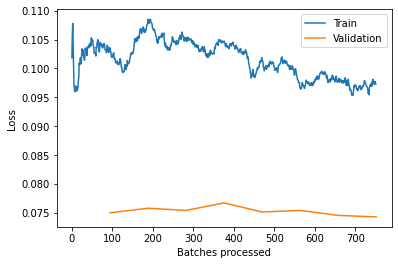

In [63]:
learn.recorder.plot_losses()

In [74]:
learn.save('../../../models/m64x64top2')

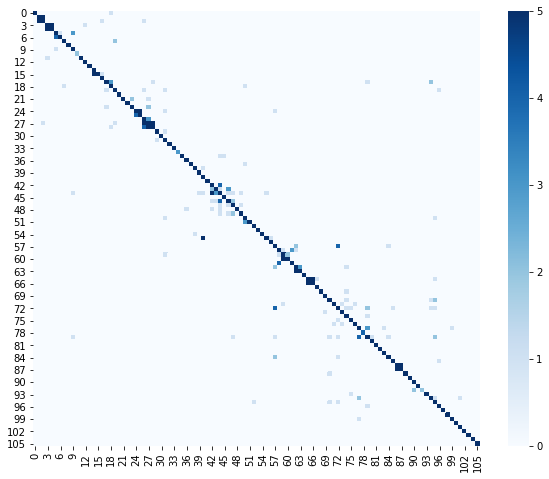

In [65]:
interpret = ClassificationInterpretation.from_learner(learn)

confusion_matrix = interpret.confusion_matrix()
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, vmin=0, vmax=5, cmap='Blues');

In [66]:
tp_vec = np.diag(confusion_matrix)
tcp_vec = np.sum(confusion_matrix, axis=0)
pcp_vec = np.sum(confusion_matrix, axis=1)
mmask = (tcp_vec != 0) & (pcp_vec != 0)
tp_vec = tp_vec[mmask]
tcp_vec = tcp_vec[mmask]
pcp_vec = pcp_vec[mmask]

precision_vec = tp_vec / pcp_vec
recall_vec = tp_vec / tcp_vec
eps_vec = np.ones_like(precision_vec) * 1e-8
f1_vec = 2 * precision_vec * recall_vec / (precision_vec + recall_vec + eps_vec)

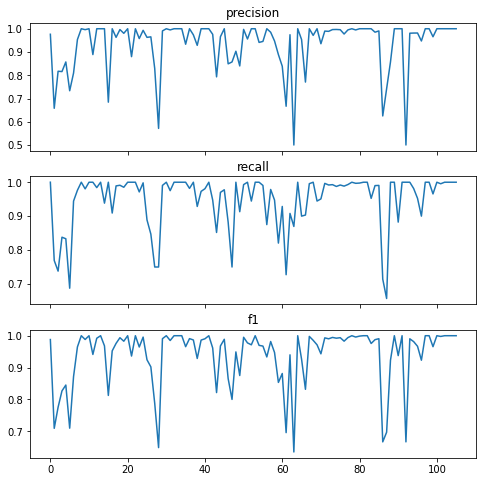

In [67]:
_, ax = plt.subplots(nrows=3, sharex=True, figsize=(8, 8))
plt.subplots_adjust(hspace=0.2)
classes = np.arange(confusion_matrix.shape[0])
x_vec = classes[mmask]
sns.lineplot(x_vec, precision_vec, ax=ax[0]).set_title('precision')
sns.lineplot(x_vec, recall_vec, ax=ax[1]).set_title('recall')
sns.lineplot(x_vec, f1_vec, ax=ax[2]).set_title('f1');

In [69]:
bad_cfn_classes = x_vec[f1_vec < 0.75]
bad_cfn_classes, f'{len(bad_cfn_classes) / len(x_vec) * 100:.2f}%'

(array([ 1,  5, 28, 61, 63, 86, 87, 92]), '7.55%')

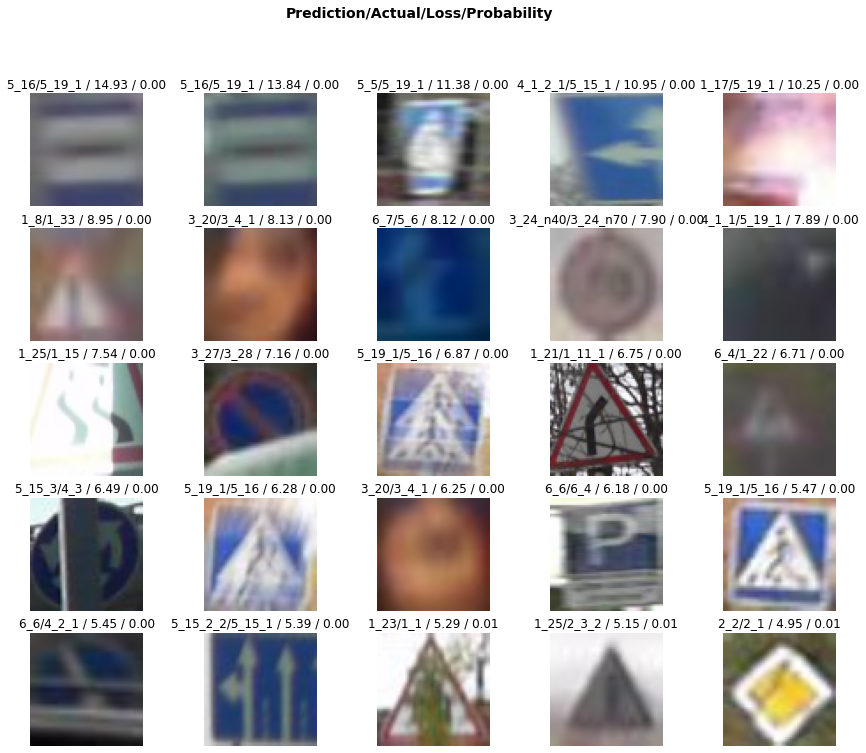

In [71]:
interpret.plot_top_losses(25, figsize=(15, 12))

In [9]:
ds_root = Path('./datasets/rtsd-r3')

size = (64, 64)
bs = 512


train_df = pd.read_csv(ds_root / 'gt_train.csv', index_col='filename')
val_df = pd.read_csv(ds_root / 'gt_test.csv', index_col='filename')
ntc_df = pd.read_csv(ds_root / 'numbers_to_classes.csv', index_col='class_number')


def get_label(p):
    folder_name = p.parent.name
    img_name = p.name
    
    df = train_df if folder_name == 'train' else val_df
    return ntc_df.loc[df.loc[img_name][0]][0]


data = (ImageList.from_folder(ds_root)
        .split_by_folder(train='train', valid='test')
        .label_from_func(get_label)
        .transform(get_transforms(), size=size) 
        .databunch(bs=bs)
        .normalize(imagenet_stats))

/eng/projects/traffic_signs/venv/lib/python3.7/site-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
6_2_n20
  if getattr(ds, 'warn', False): warn(ds.warn)


In [10]:
learn = cnn_learner(data, models.squeezenet1_1, metrics=[accuracy]).to_fp16() 
learn.load('../../../models/m64x64top2')

RuntimeError: Error(s) in loading state_dict for Sequential:
	size mismatch for 1.8.weight: copying a param with shape torch.Size([106, 512]) from checkpoint, the shape in current model is torch.Size([105, 512]).
	size mismatch for 1.8.bias: copying a param with shape torch.Size([106]) from checkpoint, the shape in current model is torch.Size([105]).